In [229]:
import env
import acquire
import prepare_bootcamp_readme
import requests as req
import pandas as pd
import numpy as np
import utilities as utils
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
bootcamp_readme_df = pd.read_csv(env.data_path + "coding_bootcamp_readme.csv")

In [3]:
bootcamp_readme_df = prepare_bootcamp_readme.prepare_bootcamp_readme_df(bootcamp_readme_df)

NaN values
     rows  columns
0       4        1
1      15        1
2      17        2
3      19        1
4      23        1
..    ...      ...
269   983        1
270   987        1
271   989        1
272   990        1
273   993        1

[274 rows x 2 columns]
--------------------------------
Empty values
   rows  columns
0   514        2
1   565        2
2   635        2
--------------------------------


## Explore

In [4]:
bootcamp_readme_df.language.value_counts()

JavaScript                 184
Jupyter Notebook           157
HTML                        99
Python                      73
Java                        37
C#                          24
Shell                       23
CSS                         14
TypeScript                  13
Ruby                         9
PHP                          9
C                            8
TeX                          8
Kotlin                       7
C++                          6
Clojure                      5
Scala                        5
HCL                          5
PowerShell                   5
Objective-C                  4
Go                           4
R                            4
Makefile                     3
Dockerfile                   3
Processing                   2
Dart                         2
Swift                        2
Groovy                       2
FORTRAN                      1
Cuda                         1
Vue                          1
OCaml                        1
SWIG    

Web development languages seem to dominate repositores (Javascript, Java, HTML) with data science languages coming in second (Jupyter notebook and Python).

In [5]:
languages_df = pd.concat([bootcamp_readme_df.language.value_counts(), bootcamp_readme_df.language.value_counts(normalize=True)], axis=1)
languages_df.columns = ['count', 'percent']

In [6]:
print(f"Combined % of top 3 web dev languages:  {round(languages_df.loc[['JavaScript', 'HTML', 'Java']].percent.sum(), 4)}")
print(f"Combined % of top 2 data science languages:  {round(languages_df.loc[['Jupyter Notebook', 'Python']].percent.sum(), 4)}")

Combined % of top 3 web dev languages:  0.4372
Combined % of top 2 data science languages:  0.3142


In [87]:
# The dictionary entry for a language will hold the list of unique words in all the readme files
readme_words_by_language_dict = {}

for language in languages_df.index:
    all_readme_for_language = " ".join(bootcamp_readme_df[bootcamp_readme_df.language == language].readme_contents)
    
    readme_words_by_language_dict[language] = re.sub(r"[^\w\s]", "", all_readme_for_language).split()    

In [88]:
# Count the occurences of the words for each language
word_count_by_lanugage_dict = {}

for language in readme_words_by_language_dict.keys():
    word_count_by_lanugage_dict[language] = pd.Series(readme_words_by_language_dict[language]).value_counts()

In [89]:
# Make an entry in each dictionary for 'all_languages'
all_readme_text = " ".join(bootcamp_readme_df.readme_contents)

readme_words_by_language_dict['all_languages'] = re.sub(r"[^\w\s]", "", all_readme_text).split()

word_count_by_lanugage_dict['all_languages'] = pd.Series(languages_dict['all_languages']).value_counts()

In [17]:
word_counts_df = pd.concat(word_count_by_lanugage_dict.values(), axis=1, sort=False)\
.set_axis(word_count_by_lanugage_dict.keys(), axis=1, inplace=False)\
.fillna(0).apply(lambda s : s.astype(int))

In [28]:
word_counts_df.sort_values(by='all_languages', ascending=False).head(10)

,JavaScript,Jupyter Notebook,HTML,Python,Java,C#,Shell,CSS,TypeScript,Ruby,...,GCC Machine Description,Jinja,AutoHotkey,ooc,Matlab,SCSS,Rouge,Lasso,Arduino,all_languages
de,599,196,99,69,40,20,0,14,25,0,...,0,0,0,0,0,0,0,0,0,1178
bootcamp,207,287,143,141,32,61,57,24,17,42,...,0,1,1,0,5,1,3,0,4,1135
9,159,267,91,452,58,8,7,2,2,0,...,0,0,0,0,0,0,0,1,0,1121
1,299,159,128,95,75,60,27,12,32,3,...,1,0,8,0,3,0,0,1,0,1018
data,88,400,199,120,20,10,40,13,2,0,...,0,0,0,0,3,1,0,3,0,955
python,9,589,23,282,0,0,9,3,0,0,...,0,0,0,0,1,0,0,9,0,935
code,249,131,96,108,20,19,18,4,48,21,...,0,0,1,0,2,1,0,5,3,834
2,206,153,114,73,45,41,13,11,31,3,...,1,0,7,0,2,0,0,2,0,764
use,246,121,60,96,18,52,7,4,26,20,...,0,0,1,0,0,6,0,5,1,731
file,141,77,130,123,16,20,34,6,13,96,...,0,0,6,0,0,0,0,0,0,731


The top 10 words in README files for all languages are:  
1. de
1. bootcamp
1. 9
1. 1
1. data
1. python
1. code
1. 2
1. use
1. file

* Are there any words that identify web dev languages from data science languages?

In [34]:
not_js_in_python = word_counts_df[word_counts_df.JavaScript == 0].sort_values(by='Python').tail(10)
not_js_in_jupyter = word_counts_df[word_counts_df.JavaScript == 0].sort_values(by='Jupyter Notebook').tail(10)

In [36]:
not_java_in_python = word_counts_df[word_counts_df.Java == 0].sort_values(by='Python').tail(10)
not_java_in_jupyter = word_counts_df[word_counts_df.Java == 0].sort_values(by='Jupyter Notebook').tail(10)

In [37]:
not_html_in_python = word_counts_df[word_counts_df.HTML == 0].sort_values(by='Python').tail(10)
not_html_in_jupyter = word_counts_df[word_counts_df.HTML == 0].sort_values(by='Jupyter Notebook').tail(10)

In [38]:
data_sci_words_df = pd.concat([not_html_in_jupyter, not_html_in_python, not_java_in_jupyter, not_java_in_python, not_js_in_jupyter,\
                               not_js_in_python])

In [41]:
# Words usually found in data science README files, but not in web dev
data_sci_words_df.index.unique()

Index(['selecione', 'dynamic', 'kln', 'wget', 'conda', 'computational', 'cell',
       'tensorflow', 'jezyku', 'x', 'car', 'ile', 'milvus', 'veri', 'bu', 'la',
       'olarak', 'django', 'reward', 'bir', 'panda', 'neural', 'w', 'analysis',
       'university', 'science', 'jupyter', 'notebook', 'python', 'heroku',
       'track', 'module', 'print', 'function', 'visualization', 'anaconda',
       'def', 'pycharm', 'steering', 'selenium', 'deepracer', 'race', 'agent'],
      dtype='object')

In [ ]:
not_python_in_js = word_counts_df[word_counts_df.Python == 0].sort_values(by='JavaScript').tail(10)
not_jupyter_in_js = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='JavaScript').tail(10)

In [45]:
not_python_in_java = word_counts_df[word_counts_df.Python == 0].sort_values(by='Java').tail(10)
not_jupyter_in_java = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='Java').tail(10)

In [46]:
not_python_in_html = word_counts_df[word_counts_df.Python == 0].sort_values(by='HTML').tail(10)
not_jupyter_in_html = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='HTML').tail(10)

In [47]:
web_dev_words_df = pd.concat([not_jupyter_in_html, not_jupyter_in_java, not_jupyter_in_js, not_python_in_html, not_python_in_java, not_python_in_js])

In [48]:
web_dev_words_df.index.unique()

Index(['id', '25transparent', '50rgba25525525515', 'cosmos', 'var', 'li',
       'signalr', 'cs', 'flight', '1px', 'pacote', 'robolectric', 'odev',
       'cordapp', 'genymotion', 'treasure', 'expense', 'layout', 'checkpoint',
       'android', 'width100px', 'altbr', 'h3', 'hr', 'td', 'yarn', 'nodejs',
       'npm', 'columbia', 'com', 'rstudio', 'azure', 'criacao', 'intent',
       'spring', 'aula', 'uma', 'desafio', 'na', 'em', 'projeto', 'um',
       'react'],
      dtype='object')

In [52]:
word_counts_df['web_dev_languages'] = word_counts_df.Java + word_counts_df.HTML + word_counts_df.JavaScript

In [53]:
word_counts_df['data_sci_languages'] = word_counts_df['Jupyter Notebook'] + word_counts_df['Python']

In [55]:
word_counts_df['other_languages'] = word_counts_df.all_languages - word_counts_df.data_sci_languages - word_counts_df.web_dev_languages

In [56]:
word_counts_df

,JavaScript,Jupyter Notebook,HTML,Python,Java,C#,Shell,CSS,TypeScript,Ruby,...,ooc,Matlab,SCSS,Rouge,Lasso,Arduino,all_languages,web_dev_languages,data_sci_languages,other_languages
de,599,196,99,69,40,20,0,14,25,0,...,0,0,0,0,0,0,1178,738,265,175
e,342,123,74,33,21,6,0,6,19,1,...,0,0,0,0,0,0,692,437,156,99
1,299,159,128,95,75,60,27,12,32,3,...,0,3,0,0,1,0,1018,502,254,262
javascript,267,1,51,3,1,0,0,17,17,13,...,0,0,0,0,0,0,378,319,4,55
code,249,131,96,108,20,19,18,4,48,21,...,0,2,1,0,5,3,834,365,239,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nunchuck,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
wii,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
novice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
assam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


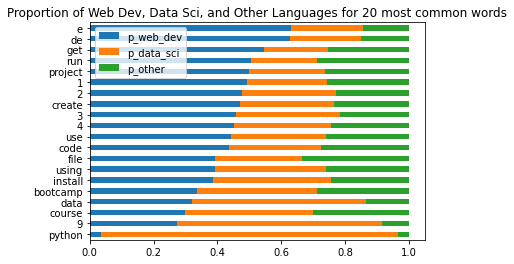

In [81]:
(word_counts_df.assign(p_web_dev=word_counts_df.web_dev_languages / word_counts_df.all_languages, \
                      p_data_sci=word_counts_df.data_sci_languages / word_counts_df.all_languages, \
                     p_other=word_counts_df.other_languages / word_counts_df.all_languages).sort_values(by='all_languages')\
[['p_web_dev', 'p_data_sci', 'p_other']]\
.tail(20).sort_values('p_web_dev').plot.barh(stacked=True))

plt.title('Proportion of Web Dev, Data Sci, and Other Languages for 20 most common words')
plt.legend(loc="best")
plt.show()

* 'Python' and 'data' are overwhelmingly in data science repositories
* 'e' and 'de' are present web dev repositories
    * Are these fragments of HTML elements or CSS selectors?

(-0.5, 799.5, 999.5, -0.5)

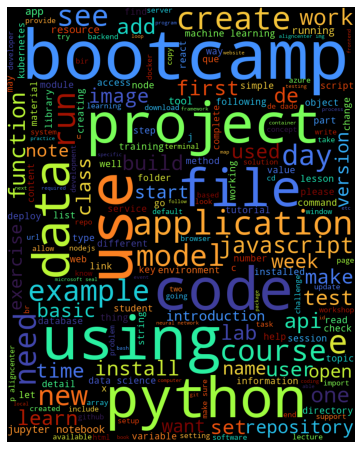

In [186]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="turbo")\
    .generate(" ".join(readme_words_by_language_dict['all_languages']))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

In [117]:
web_dev_word_list = \
list(set(readme_words_by_language_dict['Java'] + readme_words_by_language_dict['JavaScript'] + readme_words_by_language_dict['HTML']))

In [118]:
data_sci_word_list = list(set(readme_words_by_language_dict['Jupyter Notebook'] + readme_words_by_language_dict['Python']))

(-0.5, 799.5, 999.5, -0.5)

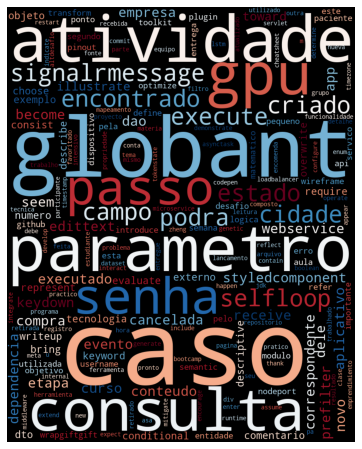

In [179]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="RdBu")\
    .generate(" ".join(web_dev_word_list))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

(-0.5, 799.5, 999.5, -0.5)

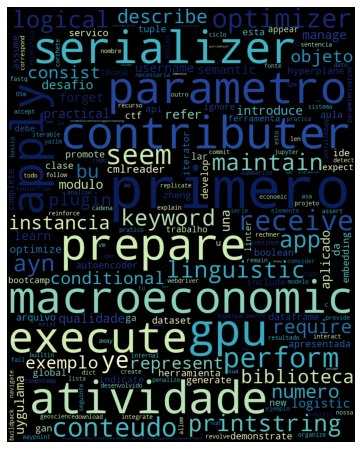

In [182]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="YlGnBu")\
    .generate(" ".join(data_sci_word_list))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

In [197]:
# Bigrams
top_20_webdev_bigrams = pd.Series(nltk.ngrams(web_dev_word_list, 2)).value_counts().head(20)
top_20_webdev_bigrams.head()

(disruptive, eggheadiohttpseggheadio)                             1
(httpdlabberkeleyedutrainingrfundamentalspart116, feild)          1
(cmd, lia)                                                        1
(optimize, bacmajaxsetupjsonpcallbackjsonpcallbackfunctionvar)    1
(dbseedall, bifvtestbreturn)                                      1
dtype: int64

In [196]:
# Bigrams
top_20_datasci_bigrams = pd.Series(nltk.ngrams(data_sci_word_list, 2)).value_counts().head(20)
top_20_datasci_bigrams.head()

(making, beginnerfriendly)                                                          1
(optimizing, martino)                                                               1
(fear, luego)                                                                       1
(mysqlpwd, leadershiphttpsgithubcomopensourcemacrobootcamp20181osmlableadership)    1
(pr, entertainment)                                                                 1
dtype: int64

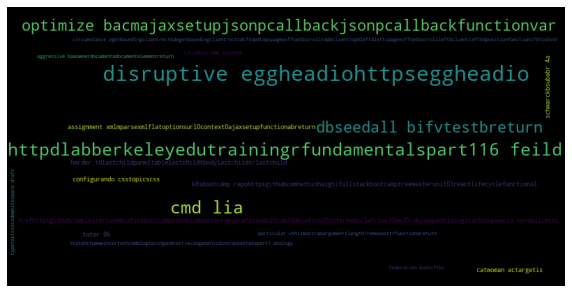

In [205]:
# Generate wordcloud following example from curriculum
data = {k[0] + ' ' + k[1]: v for k, v in top_20_webdev_bigrams.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

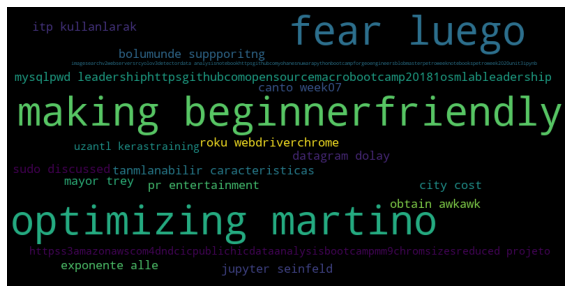

In [206]:
# Generate wordcloud following example from curriculum
data = {k[0] + ' ' + k[1]: v for k, v in top_20_datasci_bigrams.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [208]:
word_list = pd.Series(readme_words_by_language_dict['all_languages'])

# Make dataframe with raw count and frequencies
word_freq_df = (pd.DataFrame({'raw_count': word_list.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

word_freq_df

,raw_count,frequency,augmented_frequency
de,1178,0.006891,1.000000
bootcamp,1135,0.006640,0.963497
9,1121,0.006558,0.951613
1,1018,0.005955,0.864177
data,955,0.005587,0.810696
...,...,...,...
harikesh,1,0.000006,0.000849
facemodelpath,1,0.000006,0.000849
fleshed,1,0.000006,0.000849
clienthttpsgithubcomthoughtworksaustraliaandroidbootcampprojectcommit1f7d13322bd41c009e79f6351875d7bd0b4ddb34,1,0.000006,0.000849


In [221]:
word_freq_df.sort_values(by='frequency', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
0,de,1178,0.006891,1.000000,0.158029,0.001089
1,bootcamp,1135,0.006640,0.963497,0.129636,0.000861
2,9,1121,0.006558,0.951613,0.915608,0.006005
3,1,1018,0.005955,0.864177,0.371222,0.002211
4,data,955,0.005587,0.810696,1.046704,0.005848
5,python,935,0.005470,0.793718,1.448286,0.007922
6,code,834,0.004879,0.707980,0.936298,0.004568
7,2,764,0.004470,0.648557,0.359411,0.001606
8,use,731,0.004276,0.620543,0.843208,0.003606
9,file,731,0.004276,0.620543,1.162059,0.004969


In [209]:
# Calculate IDF
def idf(word, document_series):
    n_occurences = sum([1 for doc in document_series if word in doc])
    
    return np.log(len(document_series) / n_occurences)

In [210]:
word_freq_df = word_freq_df.reset_index()
word_freq_df = word_freq_df.rename(columns={'index' : 'word'})

In [214]:
word_freq_df['idf'] = word_freq_df.word.apply(idf, document_series=bootcamp_readme_df.readme_contents)
word_freq_df

,word,raw_count,frequency,augmented_frequency,idf
0,de,1178,0.006891,1.000000,0.158029
1,bootcamp,1135,0.006640,0.963497,0.129636
2,9,1121,0.006558,0.951613,0.915608
3,1,1018,0.005955,0.864177,0.371222
4,data,955,0.005587,0.810696,1.046704
...,...,...,...,...,...
30681,harikesh,1,0.000006,0.000849,6.595781
30682,facemodelpath,1,0.000006,0.000849,6.595781
30683,fleshed,1,0.000006,0.000849,6.595781
30684,clienthttpsgithubcomthoughtworksaustraliaandro...,1,0.000006,0.000849,6.595781


In [219]:
word_freq_df.sort_values(by='idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
30685,drivergeturl,1,0.000006,0.000849,6.595781,0.000039
14094,tutorialhttpwwwvogellacomtutorialsandroidactio...,1,0.000006,0.000849,6.595781,0.000039
14092,eemisarrayeemmapefunctionareturn,1,0.000006,0.000849,6.595781,0.000039
14091,hrefhttpstackoverflowcoma310324775225057html,1,0.000006,0.000849,6.595781,0.000039
14090,imparabr,1,0.000006,0.000849,6.595781,0.000039
22021,httpjavaoraclecom,1,0.000006,0.000849,6.595781,0.000039
14088,presurvey,1,0.000006,0.000849,6.595781,0.000039
14087,gistlergistler,1,0.000006,0.000849,6.595781,0.000039
14086,nodeappendchild,1,0.000006,0.000849,6.595781,0.000039
14085,donuldugu,1,0.000006,0.000849,6.595781,0.000039


In [216]:
word_freq_df['tf_idf'] = word_freq_df.frequency * word_freq_df.idf
word_freq_df

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
0,de,1178,0.006891,1.000000,0.158029,0.001089
1,bootcamp,1135,0.006640,0.963497,0.129636,0.000861
2,9,1121,0.006558,0.951613,0.915608,0.006005
3,1,1018,0.005955,0.864177,0.371222,0.002211
4,data,955,0.005587,0.810696,1.046704,0.005848
...,...,...,...,...,...,...
30681,harikesh,1,0.000006,0.000849,6.595781,0.000039
30682,facemodelpath,1,0.000006,0.000849,6.595781,0.000039
30683,fleshed,1,0.000006,0.000849,6.595781,0.000039
30684,clienthttpsgithubcomthoughtworksaustraliaandro...,1,0.000006,0.000849,6.595781,0.000039


In [218]:
word_freq_df.sort_values(by='tf_idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
5,python,935,0.005470,0.793718,1.448286,0.007922
2,9,1121,0.006558,0.951613,0.915608,0.006005
4,data,955,0.005587,0.810696,1.046704,0.005848
60,azure,282,0.001650,0.239389,3.130045,0.005164
9,file,731,0.004276,0.620543,1.162059,0.004969
55,docker,288,0.001685,0.244482,2.834580,0.004776
20,function,444,0.002597,0.376910,1.799990,0.004675
10,project,696,0.004072,0.590832,1.140459,0.004644
6,code,834,0.004879,0.707980,0.936298,0.004568
13,using,607,0.003551,0.515280,1.263062,0.004485


In [223]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(bootcamp_readme_df.readme_contents)
y = bootcamp_readme_df.language

In [226]:
vector_bootcamp_readme_df = pd.DataFrame(X, y)
vector_bootcamp_readme_df = vector_bootcamp_readme_df.reset_index()
vector_bootcamp_readme_df = bootcamp_readme_df.rename(columns={'index' : 'label', 0 : 'text'})

In [231]:
vector_bootcamp_readme_df.language.value_counts()

JavaScript                 184
Jupyter Notebook           157
HTML                        99
Python                      73
Java                        37
C#                          24
Shell                       23
CSS                         14
TypeScript                  13
Ruby                         9
PHP                          9
C                            8
TeX                          8
Kotlin                       7
C++                          6
Clojure                      5
Scala                        5
HCL                          5
PowerShell                   5
Objective-C                  4
Go                           4
R                            4
Makefile                     3
Dockerfile                   3
Processing                   2
Dart                         2
Swift                        2
Groovy                       2
FORTRAN                      1
Cuda                         1
Vue                          1
OCaml                        1
SWIG    

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [233]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=.3)

In [243]:
train = pd.DataFrame(dict(actual=y_train))
# validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [244]:
lm = LogisticRegression(class_weight="balanced").fit(X_train, y_train)

In [245]:
train['predicted'] = lm.predict(X_train)
# validate['predicted'] = lm.predict(X_validate)
test['predicted'] = lm.predict(X_test)

In [246]:
# Training sample
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 83.76%
---
Confusion Matrix
actual                   Arduino  AutoHotkey  C  C#  C++  CSS  Clojure  Cuda  \
predicted                                                                      
Arduino                        1           0  0   0    0    0        0     0   
AutoHotkey                     0           1  0   0    0    0        0     0   
C                              0           0  7   0    0    0        0     0   
C#                             0           0  0  14    0    0        0     0   
C++                            0           0  0   0    5    0        0     0   
CSS                            0           0  0   0    0   10        0     0   
Clojure                        0           0  0   0    0    0        3     0   
Cuda                           0           0  0   0    0    0        0     1   
Dart                           0           0  0   0    0    0        0     0   
Dockerfile                     0           0  0   1    0    0        0     0   
FO

In [239]:
# Training sample
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted))

Accuracy: 44.89%
---
Confusion Matrix
actual            C  C#  CSS  Clojure  Dockerfile  FORTRAN  \
predicted                                                    
C                 1   0    0        0           0        0   
C#                0   3    0        0           0        1   
C++               0   0    0        0           0        0   
CSS               0   0    0        0           0        0   
Clojure           0   0    0        1           0        0   
Go                0   0    0        0           0        0   
HCL               0   0    0        0           0        0   
HTML              0   0    1        0           0        0   
Java              0   0    0        0           0        0   
JavaScript        0   0    1        0           0        0   
Jupyter Notebook  0   0    0        0           0        0   
PHP               0   0    0        0           0        0   
PowerShell        0   0    0        0           0        0   
Processing        0   0    0    

In [247]:
# Test sample
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 46.94%
---
Confusion Matrix
actual            C  C#  C++  CSS  Clojure  Dart  HCL  HTML  Java  JavaScript  \
predicted                                                                       
C                 1   0    0    0        0     0    0     0     0           0   
C#                0   2    0    0        0     0    0     0     0           1   
C++               0   0    1    0        0     0    0     0     0           0   
CSS               0   1    0    0        0     0    0     1     0           2   
Clojure           0   0    0    0        1     0    0     0     0           0   
Dart              0   0    0    0        0     0    0     1     0           0   
Dockerfile        0   0    0    1        0     0    0     0     0           0   
Go                0   0    0    0        0     0    0     0     0           0   
HCL               0   0    0    0        0     0    1     0     0           0   
HTML              0   1    0    0        0     0    0     7     0      